In [1]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/arrays/masked.py:61: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.2' currently installed).
  from pandas.core import (


In [2]:
# Connect to database
conn = sqlite3.connect("../../../databases/MLB_Betting.db")

In [3]:
import os

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')


/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment/training
/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment



# CREATING PANDAS DF FOR FEATURES

In [4]:
# NEW WAY:

from utils.featureExtraction import buildFeatures

# Step 1: Load data from SQL
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)

# Step 2: Parse features JSON
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Step 3: Extract features using the utility function
X_all, y_all, feature_names = buildFeatures(df, method="raw")  


print(X_all.shape)
print(y_all.shape)
print(feature_names)
print(len(feature_names))

# Step 4: Add game_id and season back to X_all if needed
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

print(X_all.shape)

# Step 5: Split into train/test sets
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

# get the train and test sets for features and targets
X_train = df_train[feature_names]
X_test = df_test[feature_names]

Y_train = df_train["label"]
Y_test = df_test["label"]

print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

game_ids_train = df_train["game_id"]
game_ids_test = df_test["game_id"]

21972
(21972, 64)
(21972,)
['season_home_avg_runs_scored', 'season_home_avg_batting_avg', 'season_home_avg_obp', 'season_home_avg_slg', 'season_home_avg_batting_k_pct', 'season_home_avg_bb_pct', 'season_home_avg_babip', 'season_home_avg_runs_given', 'season_home_avg_era', 'season_home_avg_whip', 'season_home_avg_opponent_obp', 'season_home_avg_opponent_slg', 'season_home_avg_k_per_9', 'season_home_avg_pitching_k_pct', 'season_home_avg_bb_per_9', 'season_home_avg_hr_per_9', 'rolling_home_avg_runs_scored', 'rolling_home_avg_batting_avg', 'rolling_home_avg_obp', 'rolling_home_avg_slg', 'rolling_home_avg_batting_k_pct', 'rolling_home_avg_bb_pct', 'rolling_home_avg_babip', 'rolling_home_avg_runs_given', 'rolling_home_avg_era', 'rolling_home_avg_whip', 'rolling_home_avg_opponent_obp', 'rolling_home_avg_opponent_slg', 'rolling_home_avg_k_per_9', 'rolling_home_avg_pitching_k_pct', 'rolling_home_avg_bb_per_9', 'rolling_home_avg_hr_per_9', 'season_away_avg_runs_scored', 'season_away_avg_batting_

# LOGISTIC REGRESSION

season_home_avg_runs_scored: 0.0493
season_home_avg_batting_avg: 0.3728
season_home_avg_obp: 0.0664
season_home_avg_slg: -0.1089
season_home_avg_batting_k_pct: 0.1604
season_home_avg_bb_pct: 0.0538
season_home_avg_babip: -0.3052
season_home_avg_runs_given: -0.1531
season_home_avg_era: 0.0935
season_home_avg_whip: -0.1399
season_home_avg_opponent_obp: 0.0666
season_home_avg_opponent_slg: 0.0207
season_home_avg_k_per_9: 0.0573
season_home_avg_pitching_k_pct: -0.0252
season_home_avg_bb_per_9: 0.0318
season_home_avg_hr_per_9: -0.0562
rolling_home_avg_runs_scored: 0.0085
rolling_home_avg_batting_avg: -0.1691
rolling_home_avg_obp: 0.0341
rolling_home_avg_slg: 0.0649
rolling_home_avg_batting_k_pct: 0.0023
rolling_home_avg_bb_pct: -0.0496
rolling_home_avg_babip: 0.0970
rolling_home_avg_runs_given: 0.0200
rolling_home_avg_era: -0.0452
rolling_home_avg_whip: -0.1073
rolling_home_avg_opponent_obp: 0.1502
rolling_home_avg_opponent_slg: -0.0521
rolling_home_avg_k_per_9: 0.1173
rolling_home_avg_pitc

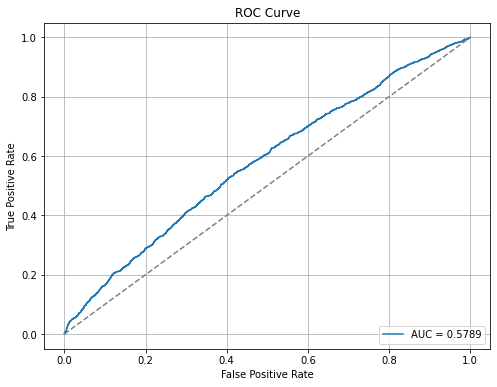

In [5]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler

# Scale for logistic regression because sensitive to scale

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Initialize logistic regression model
logreg = LogisticRegression(max_iter=1000, solver='liblinear', random_state=42) 
# Train the model
logreg.fit(X_train_scaled, Y_train)

for feature, weight in zip(X_train.columns, logreg.coef_[0]):
    print(f"{feature}: {weight:.4f}")

print(logreg.intercept_)

# exporting the model weights + features + scaler

with open('training/logistic_regression_model.pkl', 'wb') as f:
    pickle.dump(logreg, f)

with open('training/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)
    
with open('training/feature_names.pkl', 'wb') as f:
    pickle.dump(feature_names, f)

# Predict on test set
y_pred = logreg.predict(X_test_scaled)
y_proba = logreg.predict_proba(X_test_scaled)[:, 1]  

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

In [6]:
import shap
explainer = shap.Explainer(best_model)
shap_values = explainer(X_train)
shap.plots.beeswarm(shap_values)

ModuleNotFoundError: No module named 'shap'

# XGBoost

In [ ]:
import xgboost as xgb
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.model_selection import GridSearchCV, StratifiedKFold
import matplotlib.pyplot as plt


# set scale_pos_weight for class imbalance
neg, pos = np.bincount(Y_train)
scale_pos_weight = neg / pos

# 2. Define parameter grid
param_grid = {
    'max_depth': [2, 3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1],
    'n_estimators': [100, 300, 500],
    'subsample': [0.7, 0.9],
    'colsample_bytree': [0.7, 0.9],
    'reg_alpha': [0, 0.5, 1.0],
    'reg_lambda': [1.0, 2.0]
}

# 3. Initialize XGBoost Classifier
xgb_clf = xgb.XGBClassifier(
    objective='binary:logistic',
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42,
    n_jobs=-1
)

# 4. Cross-validation strategy
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 5. Grid Search
grid_search = GridSearchCV(
    estimator=xgb_clf,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=cv,
    verbose=1,
    n_jobs=-1
)

# 6. Fit and get best model
grid_search.fit(X_train, Y_train)
best_model = grid_search.best_estimator_

In [ ]:

print(best_model)
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate metrics
accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# MLP

In [14]:
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold

mlp = MLPClassifier(max_iter=200)

# Define the hyperparameter grid you want to search over
param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (100, 50)],
    'activation': ['relu', 'tanh'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001],  # L2 penalty (regularization term)
    'learning_rate': ['constant', 'adaptive']
}

# Set up GridSearchCV
grid_search = GridSearchCV(mlp, param_grid, cv=3, n_jobs=-1, verbose=2)

scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train), columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), columns=X_test.columns, index=X_test.index)

# Fit to your training data
grid_search.fit(X_train_scaled, Y_train)

# Best params & best estimator
print("Best params:", grid_search.best_params_)
best_model = grid_search.best_estimator_
y_pred = best_model.predict(X_test_scaled)
y_proba = best_model.predict_proba(X_test_scaled)[:, 1]  

accuracy = accuracy_score(Y_test, y_pred)
precision = precision_score(Y_test, y_pred)
recall = recall_score(Y_test, y_pred)
f1 = f1_score(Y_test, y_pred)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

# Detailed classification report
print("\nClassification Report:")
print(classification_report(Y_test, y_pred))

# Calculate AUC-ROC score
roc_auc = roc_auc_score(Y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

# Plot ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_proba)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()

/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED
/home/stevenwh/.local/lib/python3.9/site-packages/pandas/core/computation/expressions.py:21: UserWarning: Pandas requires version '2.8.4' or newer of 'numexpr' (version '2.7.3' currently installed).
  from pandas.core

KeyboardInterrupt: 

# Train all Models

21972

Logistic Regression:
Accuracy: 0.5578
Precision: 0.5620
Recall: 0.7099
F1 Score: 0.6274

Classification Report:
              precision    recall  f1-score   support

           0       0.55      0.39      0.46      2237
           1       0.56      0.71      0.63      2465

    accuracy                           0.56      4702
   macro avg       0.56      0.55      0.54      4702
weighted avg       0.56      0.56      0.55      4702



/scratch/gilbreth/stevenwh/envs/MyQG2/lib/python3.8/site-packages/xgboost/core.py:158: UserWarning: [01:04:55] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)



Xgboost:
Accuracy: 0.5179
Precision: 0.5362
Recall: 0.5951
F1 Score: 0.5641

Classification Report:
              precision    recall  f1-score   support

           0       0.49      0.43      0.46      2237
           1       0.54      0.60      0.56      2465

    accuracy                           0.52      4702
   macro avg       0.51      0.51      0.51      4702
weighted avg       0.52      0.52      0.51      4702


Gradient Boosting:
Accuracy: 0.5496
Precision: 0.5551
Recall: 0.7091
F1 Score: 0.6227

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.37      0.44      2237
           1       0.56      0.71      0.62      2465

    accuracy                           0.55      4702
   macro avg       0.55      0.54      0.53      4702
weighted avg       0.55      0.55      0.54      4702


Random Forest:
Accuracy: 0.5432
Precision: 0.5554
Recall: 0.6442
F1 Score: 0.5965

Classification Report:
              precision    

/scratch/gilbreth/stevenwh/envs/MyQG2/lib/python3.8/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)



TabNet:
Accuracy: 0.5553
Precision: 0.5611
Recall: 0.6970
F1 Score: 0.6217

Classification Report:
              precision    recall  f1-score   support

           0       0.54      0.40      0.46      2237
           1       0.56      0.70      0.62      2465

    accuracy                           0.56      4702
   macro avg       0.55      0.55      0.54      4702
weighted avg       0.55      0.56      0.55      4702



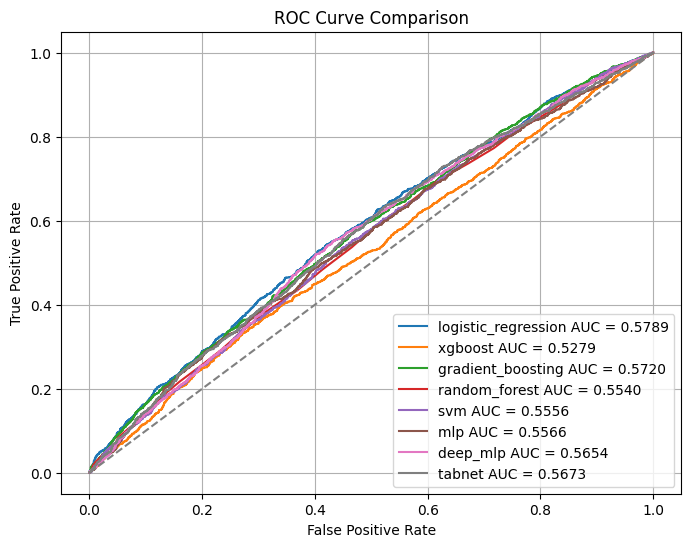


Model AUC Rankings:
logistic_regression: 0.5789
gradient_boosting: 0.5720
tabnet: 0.5673
deep_mlp: 0.5654
mlp: 0.5566
svm: 0.5556
random_forest: 0.5540
xgboost: 0.5279


In [2]:
import sqlite3
import json
import re
import pickle
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, roc_curve
from xgboost import XGBClassifier
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

try:
    from pytorch_tabnet.tab_model import TabNetClassifier
    HAS_TABNET = True
except ImportError:
    HAS_TABNET = False
    print("Run pip install pytorch-tabnet")
    
    
feature_method = "raw"

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from utils.featureExtraction import buildFeatures

# AUC tracking
auc_scores = {}
roc_curves = {}

# Connect to database
conn = sqlite3.connect("../../databases/MLB_Betting.db")

# Load data from SQL
join_query = """
SELECT 
    Features.game_id,
    OldGames.season,
    Features.features_json
FROM 
    Features
INNER JOIN 
    OldGames ON Features.game_id = OldGames.game_id
"""
df = pd.read_sql_query(join_query, conn)
df["features_json"] = df["features_json"].apply(json.loads)
df["season"] = df["season"].astype(int)

# Extract features
X_all, y_all, feature_names = buildFeatures(df, method=feature_method)
X_all = pd.concat([df[["game_id", "season"]], X_all], axis=1)
X_all["label"] = y_all

# Train/test split
df_train = X_all[X_all["season"] <= 2022]
df_test = X_all[X_all["season"] >= 2023]

X_train = df_train[feature_names]
X_test = df_test[feature_names]
Y_train = df_train["label"]
Y_test = df_test["label"]

# Scaler
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Model file directory
os.makedirs("training", exist_ok=True)

# Save scaler and feature names
with open("training/scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)
with open("training/feature_names.pkl", "wb") as f:
    pickle.dump(feature_names, f)

# Save raw versions for non-scaled models
with open("training/X_train.pkl", "wb") as f:
    pickle.dump(X_train, f)
with open("training/X_test.pkl", "wb") as f:
    pickle.dump(X_test, f)

def print_metrics(name, y_true, y_pred):
    print(f"\n{name}:")
    print(f"Accuracy: {accuracy_score(y_true, y_pred):.4f}")
    print(f"Precision: {precision_score(y_true, y_pred):.4f}")
    print(f"Recall: {recall_score(y_true, y_pred):.4f}")
    print(f"F1 Score: {f1_score(y_true, y_pred):.4f}")
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred))

# Model dictionary
model_configs = {
    "logistic_regression": (LogisticRegression(max_iter=1000), True),
    "xgboost": (XGBClassifier(use_label_encoder=False, eval_metric='logloss'), False),
    "gradient_boosting": (HistGradientBoostingClassifier(max_iter=200, random_state=42), True),
    "random_forest": (RandomForestClassifier(n_estimators=100, random_state=42), True),
    "svm": (SVC(kernel='rbf', probability=True), True)
}

for name, (model, use_scaling) in model_configs.items():
    model.fit(X_train_scaled if use_scaling else X_train, Y_train)
    y_pred = model.predict(X_test_scaled if use_scaling else X_test)
    y_proba = model.predict_proba(X_test_scaled if use_scaling else X_test)[:, 1]
    print_metrics(name.replace('_', ' ').title(), Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves[name] = (fpr, tpr)
    auc_scores[name] = roc_auc
    with open(f"training/{name}_model.pkl", "wb") as f:
        pickle.dump(model, f)

# MLP
class MLP(nn.Module):
    def __init__(self, input_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, 64)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        return self.fc2(x)

mlp_model = MLP(X_train_scaled.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mlp_model.parameters(), lr=0.001)

train_dataset = TensorDataset(torch.tensor(X_train_scaled, dtype=torch.float32), torch.tensor(Y_train.values, dtype=torch.long))
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

mlp_model.train()
for epoch in range(10):
    for xb, yb in train_loader:
        optimizer.zero_grad()
        preds = mlp_model(xb)
        loss = criterion(preds, yb)
        loss.backward()
        optimizer.step()

mlp_model.eval()
with torch.no_grad():
    logits = mlp_model(torch.tensor(X_test_scaled, dtype=torch.float32))
    y_pred = logits.argmax(dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["mlp"] = (fpr, tpr)
auc_scores["mlp"] = roc_auc

torch.save(mlp_model.state_dict(), "training/mlp_model.pt")

# Deep MLP with Dropout
class DeepMLP(nn.Module):
    def __init__(self, input_size):
        super(DeepMLP, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, 64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(64, 2)
        )

    def forward(self, x):
        return self.model(x)

X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train.values, dtype=torch.long)

train_dataset = TensorDataset(X_train_tensor, Y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

deep_mlp = DeepMLP(X_train.shape[1])
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(deep_mlp.parameters(), lr=0.001)

for epoch in range(20):
    deep_mlp.train()
    for xb, yb in train_loader:
        optimizer.zero_grad()
        outputs = deep_mlp(xb)
        loss = criterion(outputs, yb)
        loss.backward()
        optimizer.step()

deep_mlp.eval()
with torch.no_grad():
    logits = deep_mlp(X_test_tensor)
    y_pred = torch.argmax(logits, dim=1).numpy()
    y_proba = torch.softmax(logits, dim=1)[:, 1].numpy()
print_metrics("Deep MLP", Y_test, y_pred)
roc_auc = roc_auc_score(Y_test, y_proba)
fpr, tpr, _ = roc_curve(Y_test, y_proba)
roc_curves["deep_mlp"] = (fpr, tpr)
auc_scores["deep_mlp"] = roc_auc

torch.save(deep_mlp.state_dict(), "training/deep_mlp_model.pt")

# TabNet
if HAS_TABNET:
    tabnet = TabNetClassifier(verbose=0)
    tabnet.fit(X_train.values, Y_train.values)
    y_pred = tabnet.predict(X_test.values)
    y_proba = tabnet.predict_proba(X_test.values)[:, 1]
    print_metrics("TabNet", Y_test, y_pred)
    roc_auc = roc_auc_score(Y_test, y_proba)
    fpr, tpr, _ = roc_curve(Y_test, y_proba)
    roc_curves["tabnet"] = (fpr, tpr)
    auc_scores["tabnet"] = roc_auc

    with open("training/tabnet_model.pkl", "wb") as f:
        pickle.dump(tabnet, f)

# Plot all models
plt.figure(figsize=(8, 6))
for model_name, (fpr, tpr) in roc_curves.items():
    plt.plot(fpr, tpr, label=f"{model_name} AUC = {auc_scores[model_name]:.4f}")
plt.plot([0, 1], [0, 1], linestyle="--", color="gray")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend(loc="lower right")
plt.grid()
plt.show()

# AUC Ranking
print("\nModel AUC Rankings:")
for model, score in sorted(auc_scores.items(), key=lambda x: x[1], reverse=True):
    print(f"{model}: {score:.4f}")


# Evaluating all Models

In [1]:
import sqlite3
import pandas as pd
import os
import json
import numpy as np
import sklearn
import matplotlib.pyplot as plt
import re
import pickle

os.chdir('/home/stevenwh/Desktop/MLB-Game-Prediction/src/modelDevelopment')
from evaluating.testOnCurrentSeason import main_evaluate


for model in ["logistic_regression", "gradient_boosting", "random_forest", "svm", "xgboost", "mlp", "deep_mlp", "tabnet"]:
    main_evaluate(model)

In [3]:
!cat testingOnCurrentSeason_tabnet.log

GAME INFO!, home team + odds + score comes first then away!
(778494, 'ATH', '+100', 4, 'CHC', '-118', 7)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.37066323 0.6293368 ]
home_probability = 0.6293367743492126
away_probability = 0.37066322565078735

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 1.293
expected_roi = 25.87

OUTCOME
Bet was wrong, lost 1.293 units
total running profit is -1.293


GAME INFO!, home team + odds + score comes first then away!
(778487, 'LAD', '-122', 3, 'ATL', '+104', 1)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.3791464 0.6208536]
home_probability = 0.6208536028862
away_probability = 0.37914639711380005

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 0.791
expected_roi = 15.83

OUTCOME
Bet was correct!
Profitted 0.648360655737705 units
total running profit is -0.644639344262295


GAME INFO!, home team + odds + score comes first then away!
(778480, 'CIN', '-134', 0, 'TEX', '+116', 1)

MODEL PREDICTION PRO


GAME INFO!, home team + odds + score comes first then away!
(777378, 'KC', '-142', 1, 'TB', '+120', 5)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.44998103 0.55001897]
home_probability = 0.5500189661979675
away_probability = 0.44998103380203247

UNIT SIZE RECOMMENDATION
GAME INFO!, home team + odds + score comes first then away!
(777383, 'CHW', '+138', 1, 'AZ', '-164', 4)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.5799657  0.42003432]
home_probability = 0.4200343191623688
away_probability = 0.5799657106399536

UNIT SIZE RECOMMENDATION
GAME INFO!, home team + odds + score comes first then away!
(777373, 'STL', '+102', 8, 'CHC', '-120', 7)

MODEL PREDICTION PROBABILITIES, first is away, 2nd is home
[0.4233738 0.5766262]
home_probability = 0.576626181602478
away_probability = 0.4233737885951996

UNIT SIZE RECOMMENDATION
teamToBetOn = home
unit_size = 0.808
expected_roi = 16.16

OUTCOME
Bet was correct!
Profitted 0.8241600000000001 units
total runnin